In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import yfinance as yf

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers=1, bidirectional=False):
        super(lstm, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, bidirectional=bidirectional)
        if bidirectional:
            self.linear = nn.Linear(2 * num_layers * hidden_size, output_size)
        else:
            self.linear = nn.Linear(num_layers * hidden_size, output_size)
    def forward(self, x):
        batch_size = x.size(0)
        _, (hn, cn) = self.lstm(x.permute(1,0,2))
        return self.linear(hn.permute(1,0,2).view(batch_size, -1))

In [4]:
class cnn_1D(nn.Module):
    def __init__(self, input_length, in_channels, out_channels, conv_kernel_size, pool_kernel_size, conv_stride, pool_stride, output_size):
        super(cnn_1D, self).__init__()
        self.module_list = torch.nn.ModuleList()
        self.module_list.append(torch.nn.Conv1d(in_channels, out_channels[0], conv_kernel_size[0], stride=conv_stride[0]))
        L_out = (input_length - conv_kernel_size[0])//conv_stride[0] + 1
        self.module_list.append(torch.nn.MaxPool1d(pool_kernel_size[0], stride=pool_stride[0]))
        L_out = (L_out - pool_kernel_size[0])//pool_stride[0] + 1
        for i in range(1, len(conv_kernel_size)):
            self.module_list.append(torch.nn.Conv1d(out_channels[i-1], out_channels[i], conv_kernel_size[i], stride=conv_stride[i]))
            L_out = (L_out - conv_kernel_size[i])//conv_stride[i] + 1
            self.module_list.append(torch.nn.MaxPool1d(pool_kernel_size[i], stride=pool_stride[i]))
            L_out = (L_out - pool_kernel_size[i])//pool_stride[i] + 1
        self.linear = nn.Linear(L_out * out_channels[-1], output_size)
    def forward(self, x):
        batch_size = x.size(0)
        x = x.permute(0,2,1)
        for i, model in enumerate(self.module_list):
            x = model(x)
            if i % 2:
                x = F.relu(x)
        #return self.linear(x.view(batch_size, -1))
        return self.linear(torch.reshape(x, (batch_size, -1)))

In [5]:
class DA_RNN(nn.Module):
    def __init__(self, input_size, T, hidden_size, input_size2):
        super(DA_RNN, self).__init__()
        self.input_size = input_size
        self.T = T
        self.hidden_size = hidden_size
        self.input_size2 = input_size2
        
        self.lstm = nn.LSTM(self.input_size, self.hidden_size)
        # define attention layer
        self.linear = nn.Linear(self.T + self.hidden_size * 2, self.T, False)
        self.linear2 = nn.Linear(self.T, 1, False)
        
        self.lstm2 = nn.LSTM(1, hidden_size)
        # define attention layers which are linear of tanh layers
        self.linear3 = nn.Linear(input_size2 - 1 + hidden_size * 2, input_size2 - 1, False)
        self.v = nn.Linear(input_size2 - 1, 1, False)
        self.linear4 = nn.Linear(input_size2, 1)
        self.linear5 = nn.Linear(hidden_size + input_size2 - 1, hidden_size)
        self.linear6 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x size is batch * T * (input_size + 1)
        x1, x2 = torch.split(x, [x.shape[2] - 1, 1], dim=2)
        
        batch_size = x1.shape[0]
        h = self.init_state(batch_size, self.hidden_size)
        c = self.init_state(batch_size, self.hidden_size)
        h_out=torch.zeros(self.T, batch_size, self.hidden_size, device = device)
        
        for i in range(self.T):
            # first calculate input attention
            concat_hc = torch.cat((h, c), 2).permute(1,0,2).repeat(1, self.input_size, 1)
            # concat_hc has a size of batch_size * input_size * 2 hidden_size
            out = self.linear(torch.cat((concat_hc, x1.permute(0, 2, 1)), 2))
            # out has a dimension of (batch_size*input_size) * T
            weight = self.linear2(torch.tanh(out)).view(batch_size, self.input_size)
            weight = torch.softmax(weight, 1)
            # weight has a size of batch * input_size
            
            # update h and c
            _, new_state = self.lstm((x1[:,i,:] * weight).unsqueeze(0), (h, c))
            h, c = new_state
            h_out[i] = h[0]
        
        d=self.init_state(batch_size,self.hidden_size)
        s=self.init_state(batch_size,self.hidden_size)
        for i in range(self.T):
            # first calculate temporal attention on h from encoder
            concat_ds = torch.cat((d, s), 2).permute(1, 0, 2).repeat(1, self.T, 1)
            out = self.linear3(torch.cat((concat_ds, h_out.permute(1, 0, 2)), 2))
            weight = self.v(torch.tanh(out)).view(batch_size, self.T)
            weight = torch.softmax(weight, 1)
            weight = weight.unsqueeze(1)
            # new h after temporal attention, batch_size * hidden
            new_h = torch.bmm(weight, h_out.permute(1, 0, 2)).squeeze(1)
            # update d and s
            _, new_state = self.lstm2((self.linear4(torch.cat((x2[:,i,:], new_h), 1))).unsqueeze(0), (d, s))
            d, s = new_state
    
        y_out = self.linear6(self.linear5(torch.cat((d.squeeze(0), new_h), 1)))
        return y_out
    def init_state(self, batch_size, hidden_size):
        return torch.zeros(1, batch_size, hidden_size, device=device)
    def init_weight(self, T, batch_size, input_size):
        return torch.zeros(1, T, batch_size, input_size, device=device)

In [6]:
def Train(model, Train_generator, Eval_X, Eval_Y, config, optimizer, criterion, print_num, EarlyStopping=None):
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.98)
    Train_loss, Val_loss = [], []
    if EarlyStopping:
        count = 0
        best_loss = float('inf')
    for epoch in range(config.epoch):
        tic = time.time()
        # Training
        num = 0
        for x, y in Train_generator:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            #if num%print_num == 0:
            #    print(loss)
            #num += 1
        Train_loss.append(loss)
        # Validation
        with torch.no_grad():
            y_pred = model(Eval_X)
        Val_loss.append(criterion(y_pred, Eval_Y))
        print('Epoch = %d, Time elapsed = %d s, Train loss = %f, Val loss = %f' 
              % (epoch + 1, time.time() - tic, Train_loss[-1], Val_loss[-1]))
        if EarlyStopping:
            if Val_loss[-1] < best_loss:
                best_loss = Val_loss[-1]
                count = 0
            elif count >= EarlyStopping:
                break
            else:
                count += 1
        scheduler.step()
    return Train_loss, Val_loss

def predict(model, X):
    with torch.no_grad():
        y_pred = model(X)
    return y_pred     

In [7]:
class get_data:
    def __init__(self, stock_symbols):
        self.stock_symbols = stock_symbols
        self.data = None
    def history(self, start, end, interval='5m'):
        data = yf.download(self.stock_symbols, start=start, end=end, interval=interval)
        data = data[data.columns[:len(self.stock_symbols)]]
        Columns = [item[1] for item in list(data.columns)]
        data.columns = Columns
        data = data.dropna(axis=0)
        self.data = data.values.astype(np.float32)  
        return self.data

In [8]:
def seq_data_gen(data, T, L, device):
    N = data.shape[0]
    data_Y = np.zeros((N - T - L, L), dtype=np.float32)
    data_X = np.zeros((N - T - L, T, data.shape[1]), dtype=np.float32)
    for index in range(N - T - L):
        data_X[index,:,:] = data[index:index + T]
        data_Y[index] = data[index + T: index + T + L, -1]
    return torch.from_numpy(data_X).to(device), torch.from_numpy(data_Y).to(device)

In [9]:
#start, end, interval ="2013-06-24", "2020-06-25", '1d'
#data_reader = get_data(['NDX'])
#data = data_reader.history(start, end, interval)
#data.shape

In [10]:
data =  pd.read_csv('new_data.csv').values[:, 1:]
data.shape

(3144, 69)

In [11]:
class parameter:
    T = 10
    hidden_size = 128
    batch_size = 256
    epoch = 150
    learning_rate = 0.01
    Test_num = 300
    print_num = 100
    dropout = 0
    target_length = 1
    num_layer = 1
    bidirectional = False
config = parameter()

In [12]:
percentage = False
if percentage:
    for i in range(data.shape[0] - 1, 0, -1):
        data[i] = (data[i] - data[i-1])/data[i-1]
    data = data[1:]
scale = StandardScaler().fit(data)
data = scale.transform(data)
data.shape

(3144, 69)

In [13]:
N = data.shape[0]
T, L, hidden_size = config.T, config.target_length, config.hidden_size
data_X, data_Y = seq_data_gen(data, T, L, device)
Train_X, Test_X = data_X.split([data_X.shape[0] - config.Test_num, config.Test_num])
Train_Y, Test_Y = data_Y.split([data_X.shape[0] - config.Test_num, config.Test_num])
Train_X, Eval_X, Train_Y, Eval_Y = train_test_split(Train_X, Train_Y, test_size=0.2)

dataset_Train = torch.utils.data.TensorDataset(Train_X, Train_Y)
Train_generator = DataLoader(dataset_Train, batch_size=config.batch_size, shuffle=True)

In [14]:
Train_X.shape, Train_Y.shape

(torch.Size([2266, 10, 69]), torch.Size([2266, 1]))

In [15]:
input_size, output_size, num_layers, bidirectional = Train_X.shape[-1], Train_Y.shape[-1], config.num_layer, config.bidirectional
hidden_size = config.hidden_size
input_size, output_size, hidden_size, num_layers, bidirectional

(69, 1, 128, 1, False)

Epoch = 1, Time elapsed = 0 s, Train loss = 0.049074, Val loss = 0.025487
Epoch = 2, Time elapsed = 0 s, Train loss = 0.017478, Val loss = 0.018137
Epoch = 3, Time elapsed = 0 s, Train loss = 0.009746, Val loss = 0.010264
Epoch = 4, Time elapsed = 0 s, Train loss = 0.009425, Val loss = 0.008212
Epoch = 5, Time elapsed = 0 s, Train loss = 0.005762, Val loss = 0.005835
Epoch = 6, Time elapsed = 0 s, Train loss = 0.004093, Val loss = 0.004335
Epoch = 7, Time elapsed = 0 s, Train loss = 0.002603, Val loss = 0.003253
Epoch = 8, Time elapsed = 0 s, Train loss = 0.002780, Val loss = 0.002577
Epoch = 9, Time elapsed = 0 s, Train loss = 0.002022, Val loss = 0.002277
Epoch = 10, Time elapsed = 0 s, Train loss = 0.002654, Val loss = 0.002063
Epoch = 11, Time elapsed = 0 s, Train loss = 0.002632, Val loss = 0.002020
Epoch = 12, Time elapsed = 0 s, Train loss = 0.002801, Val loss = 0.001924
Epoch = 13, Time elapsed = 0 s, Train loss = 0.001648, Val loss = 0.001885
Epoch = 14, Time elapsed = 0 s, Tr

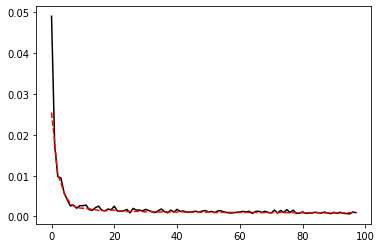

In [16]:
model1 = lstm(input_size, output_size, hidden_size, num_layers, bidirectional).to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=config.learning_rate, weight_decay = 0)
criterion = nn.MSELoss()
# Training
Train_loss1, Val_loss1 = Train(model1, Train_generator, Eval_X, Eval_Y, config, optimizer1, criterion, 20, 10)
plt.figure()
plt.plot(Train_loss1, 'k', Val_loss1, 'r--')
plt.show()

Epoch = 1, Time elapsed = 0 s, Train loss = 0.133917, Val loss = 0.413844
Epoch = 2, Time elapsed = 0 s, Train loss = 0.224300, Val loss = 0.330478
Epoch = 3, Time elapsed = 0 s, Train loss = 0.067728, Val loss = 0.094825
Epoch = 4, Time elapsed = 0 s, Train loss = 0.030925, Val loss = 0.037012
Epoch = 5, Time elapsed = 0 s, Train loss = 0.022149, Val loss = 0.020507
Epoch = 6, Time elapsed = 0 s, Train loss = 0.021037, Val loss = 0.019000
Epoch = 7, Time elapsed = 0 s, Train loss = 0.015061, Val loss = 0.017771
Epoch = 8, Time elapsed = 0 s, Train loss = 0.010526, Val loss = 0.013802
Epoch = 9, Time elapsed = 0 s, Train loss = 0.013823, Val loss = 0.013132
Epoch = 10, Time elapsed = 0 s, Train loss = 0.009974, Val loss = 0.011531
Epoch = 11, Time elapsed = 0 s, Train loss = 0.010173, Val loss = 0.011037
Epoch = 12, Time elapsed = 0 s, Train loss = 0.007435, Val loss = 0.010038
Epoch = 13, Time elapsed = 0 s, Train loss = 0.011511, Val loss = 0.009446
Epoch = 14, Time elapsed = 0 s, Tr

Epoch = 112, Time elapsed = 0 s, Train loss = 0.003276, Val loss = 0.003199
Epoch = 113, Time elapsed = 0 s, Train loss = 0.003345, Val loss = 0.003162
Epoch = 114, Time elapsed = 0 s, Train loss = 0.004080, Val loss = 0.003172
Epoch = 115, Time elapsed = 0 s, Train loss = 0.003246, Val loss = 0.003209
Epoch = 116, Time elapsed = 0 s, Train loss = 0.002877, Val loss = 0.003146
Epoch = 117, Time elapsed = 0 s, Train loss = 0.003311, Val loss = 0.003174
Epoch = 118, Time elapsed = 0 s, Train loss = 0.003337, Val loss = 0.003150
Epoch = 119, Time elapsed = 0 s, Train loss = 0.003151, Val loss = 0.003153
Epoch = 120, Time elapsed = 0 s, Train loss = 0.003721, Val loss = 0.003174
Epoch = 121, Time elapsed = 0 s, Train loss = 0.004697, Val loss = 0.003128
Epoch = 122, Time elapsed = 0 s, Train loss = 0.002604, Val loss = 0.003144
Epoch = 123, Time elapsed = 0 s, Train loss = 0.002378, Val loss = 0.003141
Epoch = 124, Time elapsed = 0 s, Train loss = 0.003852, Val loss = 0.003123
Epoch = 125,

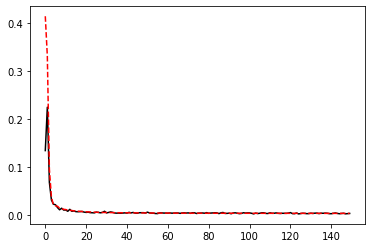

In [17]:
model2 = cnn_1D(T, input_size, [32], [5], [3], [2], [2], output_size).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=config.learning_rate, weight_decay = 0)
Train_loss2, Val_loss2 = Train(model2, Train_generator, Eval_X, Eval_Y, config, optimizer2, criterion, 20, 10)
plt.figure()
plt.plot(Train_loss2, 'k', Val_loss2, 'r--')
plt.show()

Epoch = 1, Time elapsed = 6 s, Train loss = 0.313432, Val loss = 0.416835
Epoch = 2, Time elapsed = 5 s, Train loss = 0.137005, Val loss = 0.186612
Epoch = 3, Time elapsed = 6 s, Train loss = 0.052704, Val loss = 0.044809
Epoch = 4, Time elapsed = 6 s, Train loss = 0.017453, Val loss = 0.029288
Epoch = 5, Time elapsed = 6 s, Train loss = 0.010836, Val loss = 0.012476
Epoch = 6, Time elapsed = 6 s, Train loss = 0.007279, Val loss = 0.007615
Epoch = 7, Time elapsed = 6 s, Train loss = 0.004633, Val loss = 0.003976
Epoch = 8, Time elapsed = 5 s, Train loss = 0.002661, Val loss = 0.003151
Epoch = 9, Time elapsed = 6 s, Train loss = 0.001908, Val loss = 0.001826
Epoch = 10, Time elapsed = 6 s, Train loss = 0.002353, Val loss = 0.001636
Epoch = 11, Time elapsed = 6 s, Train loss = 0.002426, Val loss = 0.001629
Epoch = 12, Time elapsed = 6 s, Train loss = 0.001716, Val loss = 0.001471
Epoch = 13, Time elapsed = 6 s, Train loss = 0.001312, Val loss = 0.001632
Epoch = 14, Time elapsed = 5 s, Tr

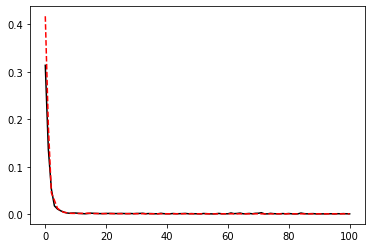

In [18]:
model3 = DA_RNN(input_size - 1, T, hidden_size, hidden_size + 1).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=config.learning_rate, weight_decay = 0)
Train_loss3, Val_loss3 = Train(model3, Train_generator, Eval_X, Eval_Y, config, optimizer3, criterion, 20, 10)
plt.figure()
plt.plot(Train_loss3, 'k', Val_loss3, 'r--')
plt.show()

0.011644777


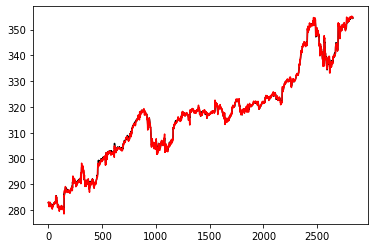

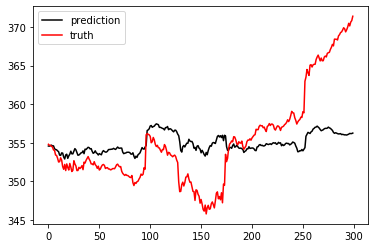

In [19]:
# first see Train data prediction
Train_Y_pred = predict(model1, data_X[:-config.Test_num])
plt.figure()
plt.plot(scale.inverse_transform(Train_Y_pred.cpu().repeat(1,data.shape[1]).numpy())[:,-1],'k',
         scale.inverse_transform(data_Y[:-config.Test_num].cpu().repeat(1,data.shape[1]).numpy())[:,-1],'r')
# see the prediction of new data
Test_Y_pred = predict(model1, Test_X)
y_pred = scale.inverse_transform(Test_Y_pred.cpu().repeat(1,data.shape[1]).numpy())[:,-1]
y_true = scale.inverse_transform(Test_Y[:, :1].cpu().repeat(1,data.shape[1]).numpy())[:,-1]
PE = np.abs((y_pred - y_true))/y_true
print(PE.mean())
plt.figure()
plt.plot(y_pred, 'k', y_true, 'r')

#plt.figure()
#plt.plot(scale.inverse_transform(Test_Y_pred.cpu().repeat(1,data.shape[1]).numpy())[:,-1],'k',
#         scale.inverse_transform(Test_Y.cpu().repeat(1,data.shape[1]).numpy())[:,-1],'r')
plt.legend(['prediction', 'truth'])

0.012807449


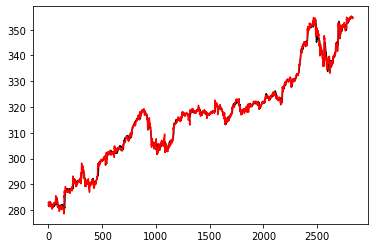

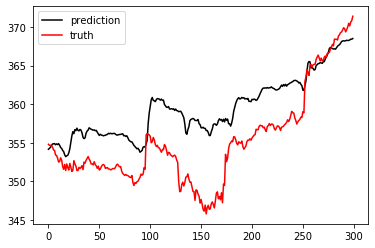

In [20]:
# first see Train data prediction
Train_Y_pred = predict(model2, data_X[:-config.Test_num])
plt.figure()
plt.plot(scale.inverse_transform(Train_Y_pred.cpu().repeat(1,data.shape[1]).numpy())[:,-1],'k',
         scale.inverse_transform(data_Y[:-config.Test_num].cpu().repeat(1,data.shape[1]).numpy())[:,-1],'r')
# see the prediction of new data
Test_Y_pred = predict(model2, Test_X)
y_pred = scale.inverse_transform(Test_Y_pred.cpu().repeat(1,data.shape[1]).numpy())[:,-1]
y_true = scale.inverse_transform(Test_Y[:, :1].cpu().repeat(1,data.shape[1]).numpy())[:,-1]
PE = np.abs((y_pred - y_true))/y_true
print(PE.mean())
plt.figure()
plt.plot(y_pred, 'k', y_true, 'r')
#plt.figure()
#plt.plot(scale.inverse_transform(Test_Y_pred.cpu().repeat(1,data.shape[1]).numpy())[:,-1],'k',
#         scale.inverse_transform(Test_Y.cpu().repeat(1,data.shape[1]).numpy())[:,-1],'r')
plt.legend(['prediction', 'truth'])

0.0015177291


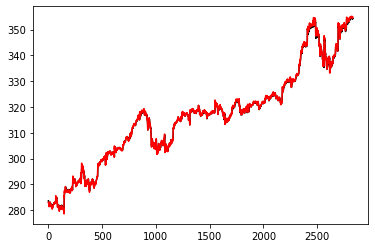

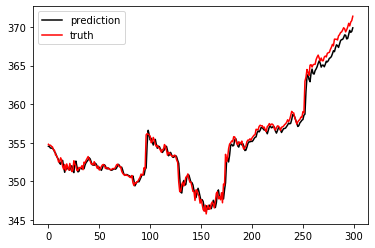

In [21]:
# first see Train data prediction
Train_Y_pred = predict(model3, data_X[:-config.Test_num])
plt.figure()
plt.plot(scale.inverse_transform(Train_Y_pred.cpu().repeat(1,data.shape[1]).numpy())[:,-1],'k',
         scale.inverse_transform(data_Y[:-config.Test_num].cpu().repeat(1,data.shape[1]).numpy())[:,-1],'r')
# see the prediction of new data
Test_Y_pred = predict(model3, Test_X)
y_pred = scale.inverse_transform(Test_Y_pred.cpu().repeat(1,data.shape[1]).numpy())[:,-1]
y_true = scale.inverse_transform(Test_Y[:, :1].cpu().repeat(1,data.shape[1]).numpy())[:,-1]
PE = np.abs((y_pred - y_true))/y_true
print(PE.mean())
plt.figure()
plt.plot(y_pred, 'k', y_true, 'r')
plt.legend(['prediction', 'truth'])